<a href="https://colab.research.google.com/github/allen44/nlp-sec-filings/blob/main/nlp_for_sec_filings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP on Financial Statements

## Packages
The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

### Mount gDrive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

% cd '/content/drive/MyDrive/Colab Notebooks/nlp-for-sec-filings'
% ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/nlp-for-sec-filings
 Bag_of_Word_Exercises.ipynb                  __pycache__/
 config.py                                    Readability_Exercises.ipynb
 Data/                                        README.md
 LoughranMcDonald_MasterDictionary_2018.csv  'request library.ipynb'
 nlp-for-sec-filings.ipynb                    requirements.txt
 project_5_starter-Copy1.ipynb                STNG.ipynb
 project_helper.py                            tests.py
 project_tests.py


In [22]:
!pip install -U -r requirements.txt
!pip install retrying

Requirement already up-to-date: alphalens>=0.3.2 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 1)) (0.4.0)
Requirement already up-to-date: nltk>=3.3.0 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 2)) (3.6.2)
Requirement already up-to-date: numpy>=1.15.4 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 3)) (1.20.2)
Requirement already up-to-date: ratelimit>=2.2.0 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 4)) (2.2.1)
Requirement already up-to-date: requests>=2.18.4 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 5)) (2.25.1)
Requirement already up-to-date: scikit-learn==0.24 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 6)) (0.24.0)
Requirement already up-to-date: six>=1.11.0 in /usr/local/lib/python3.7/dist-packages (from -r requirements.txt (line 7)) (1.15.0)
Requirement already up-to-date: tqdm>=4.19.5 in /usr/local/lib

### Load Packages

In [23]:
import nltk
import numpy as np
import pandas as pd
import pickle
#import pprintcvxpy 
import pprint
import project_helper
import project_tests
import retrying

from tqdm import tqdm

### Download NLP Corpora
You'll need two corpora to run this project: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [24]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Get 10ks
We'll be running NLP analysis on 10-k documents. To do that, we first need to download the documents. For this project, we'll download 10-ks for a few companies. To lookup documents for these companies, we'll use their CIK. If you would like to run this against other stocks, we've provided the dict `additional_cik` for more stocks. However, the more stocks you try, the long it will take to run.

In [25]:
cik_lookup = { 'AMZN': '0001018724', 'STNG':'0001483934' }

cik_lookup1 = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'STNG':'0001483934',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

### Get list of 10-ks
The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that limit, we've created the `SecAPI` class. This will cache data from the SEC and prevent you from going over the limit.

In [26]:
sec_api = project_helper.SecAPI()

With the class constructed, let's pull a list of filled 10-ks from the SEC for each company.

In [27]:
from bs4 import BeautifulSoup

@retrying.retry
def get_sec_data(cik, doc_type, start=0, count=60, sec_api=sec_api):
    newest_pricing_data = pd.to_datetime('2021-04-26')
    
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        f'&CIK={cik}&type={doc_type}&start={start}&count={count}' \
        '&owner=exclude&output=atom'
     
    print(rss_url)
    sec_data = sec_api.get(rss_url)

    # if request doesn't work, wait and try again shortly, 
    # via retyring.retry decorator
    
    try:
      # print('using encoding with ascii')
      feed = BeautifulSoup(sec_data.encode('utf-8'), 'xml').feed
      if type(feed)!=None:
        entries = [
            (
                entry.content.find('filing-href').getText(),
                entry.content.find('filing-type').getText(),
                entry.content.find('filing-date').getText())
            for entry in feed.find_all('entry', recursive=False)
            
            if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]
    except UnicodeError:
      print('using encoding with utf-8')
      feed = BeautifulSoup(sec_data.encode('utf-8'), 'xml').feed
      if type(feed)!=None:
        entries = [
            (
                entry.content.find('filing-href').getText(),
                entry.content.find('filing-type').getText(),
                entry.content.find('filing-date').getText())
            for entry in feed.find_all('entry', recursive=False)
            
            if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]
    return entries

def test_get_sec_data(cik='0001483934', doc_type='10-k', start=0, count=60):
  sec_api = project_helper.SecAPI()
  get_sec_data(cik=list(cik_lookup1.keys())[0], doc_type='10-k')
  get_sec_data(cik=list(cik_lookup1.keys())[0], doc_type='20-f')
  get_sec_data(cik=list(cik_lookup1.keys())[1], doc_type='10-k')
  get_sec_data(cik=list(cik_lookup1.keys())[1], doc_type='20-f')
  return

test_get_sec_data()



https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=AMZN&type=10-k&start=0&count=60&owner=exclude&output=atom
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=AMZN&type=20-f&start=0&count=60&owner=exclude&output=atom
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=BMY&type=10-k&start=0&count=60&owner=exclude&output=atom
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=BMY&type=20-f&start=0&count=60&owner=exclude&output=atom


Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use Amazon as an example. 

In [28]:
example_ticker = 'STNG'
sec_data = {}

for ticker, cik in cik_lookup1.items():
    if ticker != "STNG":
        print(ticker)
        sec_data[ticker] = get_sec_data(cik, '10-K')
        
    else :
        print(ticker)
        sec_data[ticker] = get_sec_data(cik, '20-F')
    

pprint.pprint(sec_data[example_ticker][:1])

AMZN
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001018724&type=10-K&start=0&count=60&owner=exclude&output=atom
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001018724&type=10-K&start=0&count=60&owner=exclude&output=atom
BMY
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000014272&type=10-K&start=0&count=60&owner=exclude&output=atom
CNP
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001130310&type=10-K&start=0&count=60&owner=exclude&output=atom
CVX
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000093410&type=10-K&start=0&count=60&owner=exclude&output=atom
FL
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000850209&type=10-K&start=0&count=60&owner=exclude&output=atom
STNG
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001483934&type=20-F&start=0&count=60&owner=exclude&output=atom
HON
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000773840&type=10-

### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [29]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):

            if ((file_type == '10-K') or (file_type == '20-F')):
                file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
                raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001483934-21-000023.txt : 20210331
<SEC-HEADER>0001483934-21-000023.hdr.sgml : 20210331
<ACCEPTANCE-DATETIME>20210331172447
ACCESSION NUMBER:		0001483934-21-000023
CONFORMED SUBMISSION TYPE:	20-F
PUBLIC DOCUMENT COUNT:		167
CONFORMED PERIOD OF REPORT:	20201231
FILED AS OF DATE:		20210331
DATE AS OF CHANGE:		20210331

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			Scorpio Tankers Inc.
		CENTRAL INDEX KEY:			0001483934
		STANDARD INDUSTRIAL CLASSIFICATION:	DEEP SEA FOREIGN TRANSPORTATION OF FREIGHT [4412]
		IRS NUMBER:				000000000

	FILING VALUES:
		FORM TYPE:		20-F
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-34677
		FILM NUMBER:		21794744

	BUSINESS ADDRESS:	
		STREET 1:		9, BOULEVARD CHARLES III
		CITY:			MONACO
		STATE:			O9
		ZIP:			98000
		BUSINESS PHONE:		212-542-1616

	MAIL ADDRESS:	
		STREET 1:		9, BOULEVARD CHARLES III
		CITY:			MONACO
		STATE:			O9
		ZIP:			98000
</SEC-HEADER>
<DOCUMENT>
<TYPE>20-F
<SEQUENCE>1
<FILENAME>stng-20201231.htm


### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [30]:
import re


def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    # Write regexes
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    
    # Create 3 lists with the span indices for each regex
    doc_start_is = [ w.end() for w in doc_start_pattern.finditer(text) ]
    doc_end_is = [ w.start() for w in doc_end_pattern.finditer(text) ]

    # Create a loop to go through each section of the text section in the list
    extracted_docs = []
    
    for ind, section in enumerate(doc_end_is):             
        extracted_docs.append(text[doc_start_is[ind]:doc_end_is[ind]])
 
    return extracted_docs


project_tests.test_get_documents(get_documents)

Tests Passed


With the `get_documents` function implemented, let's extract all the documents.

In [31]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    f'Document {doc_i} Filed on {file_date}:\n{doc[:200]}...'
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|██████████| 24/24 [00:01<00:00, 21.67filling/s]

Document 0 Filed on 2021-03-31:

<TYPE>20-F
<SEQUENCE>1
<FILENAME>stng-20201231.htm
<DESCRIPTION>20-F
<TEXT>
<XBRL>
<?xml version="1.0" ?><!--XBRL Document Created with Wdesk from Workiva--><!--Copyright 2021 Workiva--><!--r:7d49182...

Document 1 Filed on 2021-03-31:

<TYPE>EX-2.5
<SEQUENCE>2
<FILENAME>fy2020-exhibit25.htm
<DESCRIPTION>DESCRIPTION OF SECURITIES REGISTERED
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/h...

Document 2 Filed on 2021-03-31:

<TYPE>EX-2.7
<SEQUENCE>3
<FILENAME>fy2020-exhibit27.htm
<DESCRIPTION>INDENTURE, DATED MARCH 25, 2021, 3.00% CONVERTIBLE NOTES DUE 2025
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional...


### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [32]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    # Write regexes
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    
    # Create list with the span idices for each regex
    doc_types = [ w for w in type_pattern.finditer(doc) ]  
     
    extracted_docs = doc[doc_types[0].start()+6:doc_types[0].end()].lower()
 
    return extracted_docs 


project_tests.test_get_document_type(get_document_type)

Tests Passed


With the `get_document_type` function, we'll filter out all non 10-k documents.

In [41]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    print(ticker, end='')
    counter = 0
    for file_date, documents in filling_documents.items():
         
        for document in documents:
            # print(document[:200])
            if ((get_document_type(document) == '10-k') or (get_document_type(document) == '20-f') ):
                 
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup1[ticker],
                    'file': document,
                    'file_date': file_date})
                counter += 1
    print(f":\t{counter} 10-k's")

# project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

AMZN:	18 10-k's
BMY:	22 10-k's
CNP:	13 10-k's
CVX:	22 10-k's
FL:	15 10-k's
STNG:	8 10-k's
HON:	19 10-k's


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

In [42]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the `clean_text` function, we'll clean up all the documents.

In [43]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc=f'Cleaning {ticker} 10-Ks', unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning HON 10-Ks: 100%|██████████| 19/19 [00:51<00:00,  2.71s/10-K]

[
  {
    file_clean: '\n20-f\n1\nstng-20201231.htm\n20-f\n\n\n\nstng-20...},
  {
    file_clean: '\n20-f\n1\nstng2019-12x3120f.htm\nscorpio tankers...},
  {
    file_clean: '\n20-f\n1\nstng2017-20f.htm\nscorpio tankers inc....},
  {
    file_clean: '\n20-f\n1\nstng2016-12x3120f.htm\n2016 form 20-f\...},
  {
    file_clean: '\n20-f\n1\nstng2015-20f.htm\nform 20-f\n\n\n\n\n\...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [44]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    wnl = WordNetLemmatizer()
    lemmatized_word = []
    for word in words:
        lemmatized_word.append(wnl.lemmatize(word, pos='v'))
     
    return lemmatized_word


project_tests.test_lemmatize_words(lemmatize_words)

Tests Passed


With the `lemmatize_words` function implemented, let's lemmatize all the data.

In [45]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {ticker} 10-Ks', unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize {ticker} 10-Ks: 100%|██████████| 19/19 [00:04<00:00,  4.0210-K/s]

[
  {
    file_lemma: '['20', 'f', '1', 'stng', '20201231', 'htm', '20',...},
  {
    file_lemma: '['20', 'f', '1', 'stng2019', '12x3120f', 'htm', '...},
  {
    file_lemma: '['20', 'f', '1', 'stng2017', '20f', 'htm', 'scorp...},
  {
    file_lemma: '['20', 'f', '1', 'stng2016', '12x3120f', 'htm', '...},
  {
    file_lemma: '['20', 'f', '1', 'stng2015', '20f', 'htm', 'form'...},
]


### Remove Stopwords

In [46]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {ticker} 10-Ks', unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('\nStop Words Removed')

Remove Stop Words for {ticker} 10-Ks: 100%|██████████| 19/19 [00:01<00:00,  9.6710-K/s]


Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [47]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv(os.path.join( 'LoughranMcDonald_MasterDictionary_2018.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# # Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication
...,...,...,...,...,...,...,...
86035,True,False,False,False,False,False,wrongdoing
86036,True,False,False,False,False,False,wrongdoings
86040,True,False,False,False,False,False,wrongful
86041,True,False,False,False,False,False,wrongfully


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [48]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement

    bag_of_words = np.zeros((len(docs), len(sentiment_words)))
    for ind, word  in enumerate(docs):
        for sen_id, sent in enumerate(sentiment_words):
             #bag_of_words[ind, sen_id] = word.count(sent) 
            if sent in word:
                bag_of_words[ind, sen_id] = 1 
    print(bag_of_words)         
    return bag_of_words


# project_tests.test_get_bag_of_words(get_bag_of_words)

Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [ ]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


# project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. Implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Since the input, `bag_of_words_matrix`, is a bag of words for each time period in order, you just need to compute the jaccard similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.



>Jaccard Similarity

>Now that we have the bag of words, we can convert it into a boolean array and calculate the jaccard similarity. The jaccard similarity is defined as the size of intersection divided by the size of union of two sets. For example, the jaccard similarity between two sentences is the number of common words between the two sentences divided by the total number of unique words in both sentences combined. The closer the jaccard similarity value is to 1, the more similar the sets are. To more easily understand our calculations, we plot the jaccard similarities.



In [50]:
from sklearn.metrics import jaccard_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    bag_of_words = bag_of_words_matrix.astype(bool)
    
    jaccard_similarities = []
    
    len_ = len(bag_of_words)

    for in_, v in enumerate(bag_of_words[0:len_-1]):
    
        u=bag_of_words[in_+1]
  
        jaccard_similarities.append(jaccard_score(v,u))

    return jaccard_similarities

   


# project_tests.test_get_jaccard_similarity(get_jaccard_similarity)

Using the `get_jaccard_similarity` function, let's plot the similarities over time.

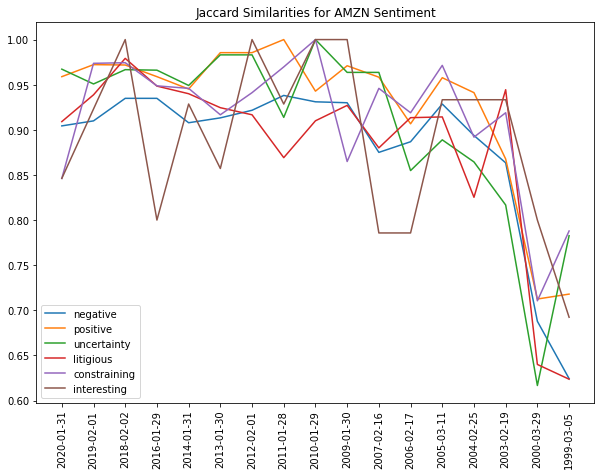

In [51]:
# Get dates for the universe
example_ticker = 'AMZN'
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.

>TFIDF

>From the sentiment word lists, let’s generate sentiment term frequency–inverse document frequency (TFIDF) from the 10-k documents. TFIDF is an information retrieval technique used to reveal how often a word/term appears in the chosen collection of text. Each term is assigned a term frequency (TF) and inverse document frequency (IDF) score. The product of these scores is referred to as the TFIDF weight of the term. Higher TFIDF weights indicate rarer terms and lower TFIDF scores indicate more common terms.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
 
    vectorizer = TfidfVectorizer( vocabulary = sentiment_words)
 
    tfidf  = vectorizer.fit_transform (docs).toarray()
 
    return tfidf


project_tests.test_get_tfidf(get_tfidf)

Tests Passed


Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [53]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0.         0.02789314 0.         ... 0.        ...
    positive: '[[0.22683333 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.00603414...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.02036679 0.         0.         ... 0.        ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [54]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """

    cosine_similarities= cosine_similarity(tfidf_matrix[0:],tfidf_matrix[1:])[0].tolist()
       
    return cosine_similarities 
    
project_tests.test_get_cosine_similarity(get_cosine_similarity)

Tests Passed


In [55]:
import matplotlib.pyplot as plt
def plot_similarities1(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

Let's plot the cosine similarities over time.

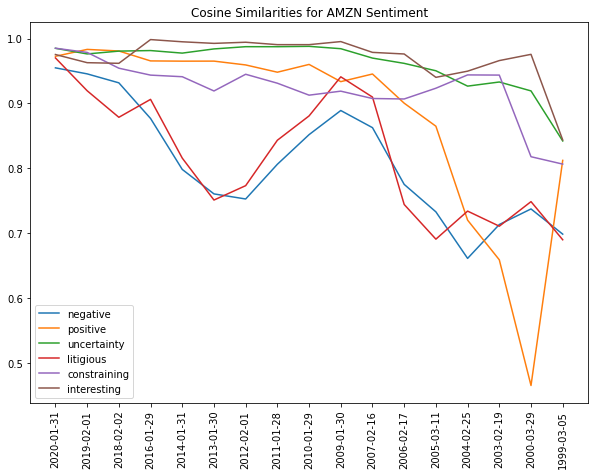

In [56]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


plot_similarities1(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    f'Cosine Similarities for {example_ticker} Sentiment',
    sentiments)

## Evaluate Alpha Factors
Just like we did in project 4, let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can be applied to the jaccard similarities as well.


### Price Data
Let's get yearly pricing to run the factor against, since 10-Ks are produced annually.

In [57]:
from pandas_datareader import data as pdr
import yfinance as yf

# use yfinance while making sure the returned data is in the same format 
# as pandas_datareader's get_data_yahoo()
yf.pdr_override()

def download_daily_data(ticker):
  # download dataframe
  df = pdr.get_data_yahoo(ticker, 
                              start=file_dates[example_ticker][-1], 
                              end=file_dates[example_ticker][1])
  df['ticker'] = ticker
  return df

test_daily_data = download_daily_data('AMZN')
test_daily_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
1999-03-05,61.96875000,62.25000000,59.18750000,60.75000000,60.75000000,12176200,AMZN
1999-03-08,60.71875000,63.21875000,59.62500000,61.09375000,61.09375000,10462600,AMZN
1999-03-09,62.56250000,66.62500000,61.71875000,64.96875000,64.96875000,16292000,AMZN
1999-03-10,68.37500000,69.46875000,67.00000000,68.56250000,68.56250000,14117600,AMZN
1999-03-11,69.87500000,71.37500000,65.50000000,67.43750000,67.43750000,16252200,AMZN
...,...,...,...,...,...,...,...
2020-01-24,1891.36999512,1894.98999023,1847.43994141,1861.64001465,1861.64001465,3766200,AMZN
2020-01-27,1820.00000000,1841.00000000,1815.33996582,1828.33996582,1828.33996582,3528500,AMZN
2020-01-28,1840.50000000,1858.10998535,1830.02001953,1853.25000000,1853.25000000,2808000,AMZN


In [58]:
# def get_price_df():
#   for ticker in list(file_dates.keys()):
#     price_series = get_daily_price_series(ticker)
#   return price_df

In [59]:
# def pivot_to_date_index_ticker_columns_price_values(daily_data_df, ticker):
#   daily_price = daily_data_df.copy()[['Adj Close']]
#   daily_price['ticker'] = ticker
#   daily_close_by_ticker = daily_price.pivot(
#                           # index='date', 
#                           columns='ticker', 
#                           values='Adj Close')
#   return daily_close_by_ticker

# test_adj_close_by_date_and_ticker = pivot_to_date_index_ticker_columns_price_values(test_daily_data, 'AMZN')
# test_adj_close_by_date_and_ticker

In [60]:
# Make dataframe with all tickers
def get_prices_for_all_tickers(ticker_list, start='2000-01-01', end='2021-04-01'):
  index=pd.date_range(start, end)
  prices = pd.DataFrame(index=index)
  for ticker in ticker_list:
    daily_price = download_daily_data(ticker).copy()[['Adj Close']]
    daily_price[ticker] = daily_price
    daily_price = daily_price.drop(columns='Adj Close')
    prices=pd.merge(prices, daily_price, how='left', left_index=True, right_index=True)
  prices.index.name = 'date'
  return prices

prices = get_prices_for_all_tickers(list(cik_lookup1.keys()))
prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AMZN,BMY,CNP,CVX,FL,STNG,HON
date,,,,,,,
2000-01-01,nan,nan,nan,nan,nan,nan,nan
2000-01-02,nan,nan,nan,nan,nan,nan,nan
2000-01-03,89.37500000,28.03261185,6.11485481,19.36047363,4.34992981,nan,33.24100494
2000-01-04,81.93750000,25.91182327,6.18355989,19.36047363,4.27225018,nan,32.65464401
2000-01-05,69.75000000,25.74581528,6.44121265,19.70774460,4.23341322,nan,32.21482086
...,...,...,...,...,...,...,...
2021-03-28,nan,nan,nan,nan,nan,nan,nan
2021-03-29,nan,nan,nan,nan,nan,nan,nan
2021-03-30,nan,nan,nan,nan,nan,nan,nan


### Dict to DataFrame
The alphalens library uses dataframes, so we we'll need to turn our dictionary into a dataframe. 

In [171]:
# Resample workaround for upsampling a multiindexed df.
# Adapted from
#  https://github.com/pandas-dev/pandas/issues/28313#issuecomment-532231669


def upsample(df, rule='D', method='ffill',
             group_index: str='ticker', date_index: str='date', 
             upsampled_date_index_level: int=0):
    """
    Upsample a Pandas DataFrame or Series with either a DatetimeIndex or
    MultiIndex. This can be used to upsample financial data for a single
    company, or upsample data for multiple companies in a single DataFrame.

    :param df:
        Pandas DataFrame or Series.

    :param rule:
        Upsampling frequency e.g. 'D' for daily.

        This is passed directly to the Pandas resampler which has more options:
        https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

    :param method:
        String for the method of filling in empty values. Valid options:
        'ffill' is forward-fill with last known values.
        'linear' is linear interpolation between known values.

    :param group_index:
        If `df` has a MultiIndex then group companies using this data-column.
        By default this is TICKER but it could also be e.g. SIMFIN_ID if
        you are using that as an index in your DataFrame.

    :param date_index:
        If `df` has a MultiIndex then use this data-column as the dates.
        By default this is REPORT_DATE but it could also be e.g. PUBLISH_DATE
        if you are using that as an index in your DataFrame.

    :return:
        Upsampled DataFrame or Series.
    """

    assert isinstance(df, (pd.DataFrame, pd.Series))
    assert isinstance(df.index, (pd.DatetimeIndex, pd.MultiIndex))
    assert method == 'ffill' or method == 'linear'
    assert upsampled_date_index_level in range(0, len(df.index.levels))

    # Pandas 0.25.1 does not support upsampling a DataFrame with a MultiIndex
    # using the normal resample() function, so we must handle the two cases
    # differently.

    # If the DataFrame has a DatetimeIndex.
    if isinstance(df.index, pd.DatetimeIndex):
        # Normal upsampling using Pandas.

        if method == 'ffill':
            # Fill with last-known value.
            df_upsampled = df.resample(rule).ffill()
        elif method == 'linear':
            # Fill with linearly interpolated values.
            df_upsampled = df.resample(rule).interpolate(method='linear')

    # If the DataFrame has a MultiIndex.
    elif isinstance(df.index, pd.MultiIndex):
        # Pandas has very complicated semantics for resampling a DataFrame
        # with a MultiIndex. The best way is apparently to group the DataFrame
        # by companies (e.g. using TICKER) which creates an individual
        # DataFrame for each company, and then apply the resampling to each
        # of those DataFrames. It is further complicated by the need to reset
        # and set the index. Pandas is quite poorly designed in this regard
        # and its resampling API has already been changed several times.

        # Helper-function for resampling a DataFrame for a single company.
        def _resample(df):
            if method == 'ffill':
                # Fill with last-known value.
                return df.set_index(date_index).resample(rule).ffill()
            elif method == 'linear':
                # Fill with linearly interpolated values.
                return df.set_index(date_index).resample(rule).interpolate(method='linear')

        # Group the original DataFrame by companies and apply the resampling to each.
        df_upsampled = df.reset_index(level=date_index).groupby(level=group_index).apply(_resample)
        if upsampled_date_index_level == 0:
          df_upsampled = df_upsampled.reset_index().set_index(['date', 'ticker'])

    return df_upsampled


In [182]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)

cosine_similarities_dfs = {}
for sentiment in cosine_similarities_df['sentiment'].unique():
  df = cosine_similarities_df
  df = df[df['sentiment']==sentiment].loc[:, ['date', 'ticker', 'value']]
  df['date'] = pd.to_datetime(df['date'])
  df = df.set_index(['date', 'ticker'])
  df = upsample(df, 
                rule='D', 
                method='ffill', 
                group_index='ticker', 
                date_index='date',
                upsampled_date_index_level=0)
  
  # new_index = pd.date_range(start=df['date'].min(),
  #                           end=df['date'].max(),
  #                           freq='D')
  # new_index = pd.DatetimeIndex(new_index)
  # new_df = pd.DataFrame(index=new_index)
  # new_df.index.name = 'date'
  # new_df = pd.merge_ordered(new_df,
  #                   df,
  #                   on='date',
  #                   how='outer',
  #                   fill_method='None')
  # new_df = new_df.set_index(['date', 'ticker'])

  # upsampled_df = upsample(new_df)
  # new_df = new_df.reset_index('ticker').groupby('ticker', group_keys=False).resample('D').pad().reset_index().set_index(['date', 'ticker'])
  # new_df = new_df.set_index('date', verify_integrity=True)
  # new_df = new_df.set_index(new_index)
  # upsampled_df = upsampled_df.reset_index().set_index(['date', 'ticker'])
  cosine_similarities_dfs[sentiment] = df
  

cosine_similarities_dfs['negative']

,,value
date,ticker,
1999-03-05,AMZN,0.69837581
1999-03-06,AMZN,0.69837581
1999-03-07,AMZN,0.69837581
1999-03-08,AMZN,0.69837581
1999-03-09,AMZN,0.69837581
...,...,...
2020-03-27,STNG,0.90980769
2020-03-28,STNG,0.90980769
2020-03-29,STNG,0.90980769


### Alphalens Format
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [185]:
import alphalens as al

# FIx bug workaround:
# Just stumbled upon this issue.
# @luca-s , you are right:
# utils.get_clean_factor_and_forward_returns(factor, prices, max_loss=0.0) (factor and prices as shown by @niti's comment) function call reveals the source of trouble: ValueError: Bin edges must be unique raised by pd.qcut inside quantile_calc, line 132.

# What it does is it groups factor by date and tries to cut every group into bins (line 165), and clearly fails, since there is no way to cut one sample (one per date) in more than one bin. But since max_loss is different from zero, no_raise is True (line 570), so exception is swallowed, quantiles for every group are set to NaN (line 158), and so the whole dataset is dropped (line 578).
# Line numbering is given for commit 32bad52.

# Therefore, in case of one asset only, one should use utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=None, bins=1) or utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=None, bins=[-np.inf, np.inf])

# Hope that someone will find it useful.

factor_data = {}
skipped_sentiments = []
aligned_prices = None

for sentiment in sentiments:
    factor_df = cosine_similarities_dfs[sentiment]
    # factor_df = factor_df.pivot(index='date', columns='asset', values='cosine_similarity')
#     index = pd.DatetimeIndex(cosine_similarities_df['date'].copy())
# cosine_similarities_df = cosine_similarities_df.drop(columns='date')
# cosine_similarities_df.index = index
# cosine_similarities_df = cosine_similarities_df.resample('B').asfreq()

    # factor_dateindex = factor_multi_index_series.index.levels[0]

    # assert len(factor_dateindex) > 0

    # Pricing data must span the factor analysis time period plus an additional 
    # buffer window that is greater than the maximum number of expected periods in the forward returns calculations.
    # if not (prices.index[0] < factor_multi_index_series.index.levels[0][0]):
    #   prices = prices.loc[]
    #   assert prices.index[0] < factor_multi_index_series.index.levels[0][0]


    # factor_multi_index_series = factor_multi_index_series.reset_index(level='ticker')
    # factor_multi_index_series = factor_multi_index_series.groupby('ticker').resample('C').asfreq()
    # factor_multi_index_series = factor_multi_index_series.resample('D', level='date')
    try:
        data = al.utils.get_clean_factor_and_forward_returns(factor_df, 
                                                             prices, 
                                                             quantiles=None, 
                                                             bins=5,
                                                            #  bins=[0, 0.25, 0.5 , 0.75, 1], 
                                                             periods=[3, 7, 14, 21, 30],
                                                             max_loss=1)
        factor_data[sentiment] = data
    
    except ValueError:
      # if len(factor_dateindex.intersection(prices.index)) == 0:
      #   # All dates of all facotrs are on a trading holiday, like Jan 1, so no prices
      #   # Shift interpolate the next price
      #   aligned_prices, temp  =  align_index_of_prices_df_to_cosine_similarities_df(prices_df=prices.copy(), 
      #                                             cs_df=cosine_similarities_df.copy(), 
      #                                             sentiment=sentiment,
      #                                             ticker='AMZN')
      #   data = al.utils.get_clean_factor_and_forward_returns(factor_df, aligned_prices, quantiles=5, bins=None, periods=[1],  max_loss=0)
      #   factor_data[sentiment] = data
      # else:
      #   # data = al.utils.get_clean_factor_and_forward_returns(factor_df, prices, quantiles=5, bins=None, periods=[1], max_loss=0)
      #   # factor_data[sentiment] = data
      skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

Dropped 12.3% entries from factor data: 12.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 12.3% entries from factor data: 12.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 12.3% entries from factor data: 12.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 12.3% entries from factor data: 12.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 12.3% entries from factor data: 12.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


,,3D,7D,14D,21D,30D,factor,factor_quantile
date,asset,,,,,,,
2000-01-03,AMZN,-0.26643357,-0.22587413,-0.28111888,-0.21538462,-0.22307692,0.69837581,5
2000-01-04,AMZN,-0.15102975,-0.18535469,-0.21739130,-0.15484363,0.02745995,0.69837581,5
2000-01-05,AMZN,-0.00268817,-0.08870968,-0.04211470,-0.07078853,0.12634409,0.69837581,5
2000-01-06,AMZN,0.06101049,0.00571973,-0.01239276,0.02097235,0.19828408,0.69837581,5
2000-01-07,AMZN,-0.00539084,-0.07637017,-0.10781671,-0.11320755,0.12938005,0.69837581,5


### Alphalens Format with Unix Time
Alphalen's `factor_rank_autocorrelation` and `mean_return_by_quantile` functions require unix timestamps to work, so we'll also create factor dataframes with unix time.

In [254]:
def datetime_to_epoch(ser):
    """Don't convert NaT to large negative values."""
    if ser.hasnans:
        res = ser.dropna().astype('int64').astype('Int64').reindex(index=ser.index)
    else:
        res = ser.astype('int64')

    return res // 10**9

In [270]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

In [260]:
unixt_factor_data['constraining']

,,3D,7D,14D,21D,30D,factor,factor_quantile
date,asset,,,,,,,
946857600.00000000,AMZN,-0.26643357,-0.22587413,-0.28111888,-0.21538462,-0.22307692,0.80638603,5
946944000.00000000,AMZN,-0.15102975,-0.18535469,-0.21739130,-0.15484363,0.02745995,0.80638603,5
947030400.00000000,AMZN,-0.00268817,-0.08870968,-0.04211470,-0.07078853,0.12634409,0.80638603,5
947116800.00000000,AMZN,0.06101049,0.00571973,-0.01239276,0.02097235,0.19828408,0.80638603,5
947203200.00000000,AMZN,-0.00539084,-0.07637017,-0.10781671,-0.11320755,0.12938005,0.80638603,5


### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

In [215]:
ls_factor_returns = pd.DataFrame()
for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]
ls_factor_returns.index = pd.to_datetime(ls_factor_returns.index)

ls_factor_returns.head()

,negative,positive,uncertainty,litigious,constraining,interesting
date,,,,,,
2000-01-03,-0.03945487,-0.01831068,0.00404336,0.02702878,-0.01919714,-0.01763215
2000-01-04,-0.06503495,-0.02452947,-0.07863293,0.02846164,-0.02285956,0.00479103
2000-01-05,-0.03713849,-0.01414131,-0.06092128,0.01076666,-0.01256986,0.00790475
2000-01-06,-0.02151329,-0.00801219,-0.05480394,0.00025869,-0.00635776,0.01121648
2000-01-07,-0.00793441,-0.01233761,-0.00239772,-0.01345978,-0.01217644,-0.01109099


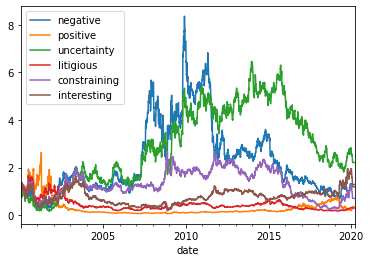

In [216]:
(1 + ls_factor_returns).cumprod().plot()

Lets look at only 2019 through 2021.

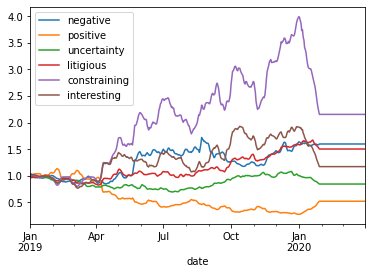

In [217]:
(1 + ls_factor_returns.loc['2019':,:]).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

In [218]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]
qr_factor_returns = qr_factor_returns.set_index(pd.to_datetime(qr_factor_returns.index))

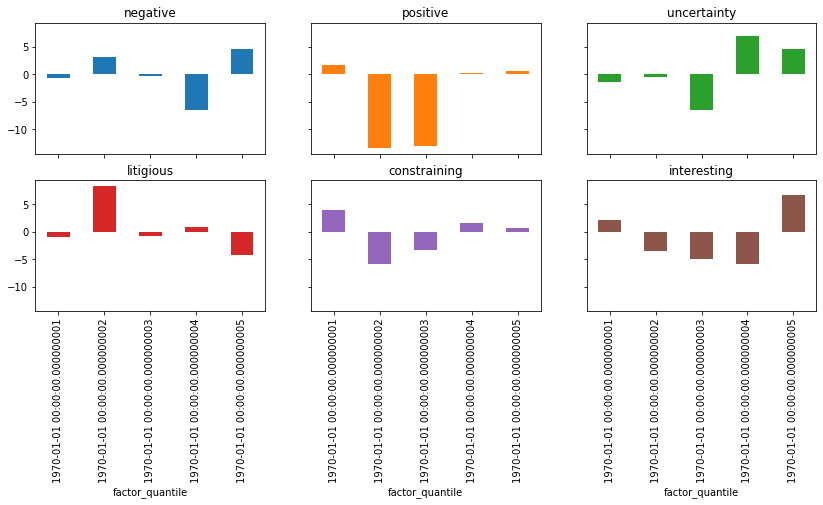

In [219]:
(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False);

### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **Factor Rank Autocorrelation (FRA)**.

In [250]:
ls_FRA = pd.DataFrame()

for factor, data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)
ls_FRA.index = pd.to_datetime((ls_FRA.index*1e9).astype('int64'))


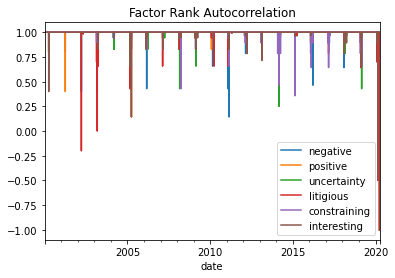

In [251]:
ls_FRA.plot(title="Factor Rank Autocorrelation");

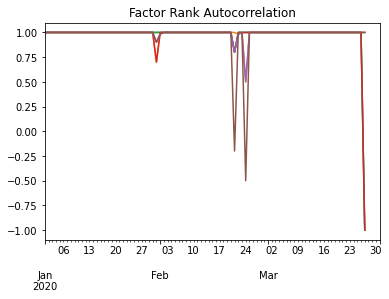

In [243]:
ls_FRA.loc['2020':,:].resample('Q').plot(title="Factor Rank Autocorrelation");

# Write-up


The notebook didn't run all the way through out-of-the-box. I made some changes to make it work. Unfortunately, I spent too much time debugging a library (alphalens) that isn't updated anymore and was lacking core functionality to do the analysis without making the bias that the notebook author made.

The alphalens documentation seems to show that all data points must have the same frequency ex pd.datetime frequency ='D', or 'M', or Y. However, we know the SEC filings are nearly never filed on a constant cadence, and filings across companies do not happen on the same day.. The original author of the notebook compromises, introducing bias, by: 
setting all companies SEC filing date to the same date
setting all SEC filings to the first date of the year.

There may be a better-equipped library that already does what I'm looking for.

## Changes

The changes I made include:

* Update requirements.txt to use newest versions, when compatible

* Install retrying module, and add @retry decorators to get_sec() so that the function retries checking the SEC RSS feed a few times until it gets all the required data, instead of gathering NoneType data, then continuing to throw an exception later.

* Import jaccard_score from sklearn.metrics, instead of jaccard_similarity. The function name as changed in sklearn 0.24, and the old function name was removed. 

* Add working data source (yfinance, via Yahoo Finance) for price data. The author had left the notebook user to get their own data, possibly due to licensing issues.

* Make cosine_similarities_dfs variable fit the alphalens documentation's expected parameters (Multi-index series).

* Change min period for alpha calulations to 3, instead of 1, to avoid unpredictable look-back bias due to ambiguity on if sec filings were made before market hours, or after market hours, on any given trading day.

* Delete the section titled, "Sharpe Ratio of the Alphas". The math makes no sense, as-implemented, and neither does the title.





## Future work:

* Find a better price data source for EOD data. Yahoo Finance doesn't go back vary far. QuantConnect  is where I'll look next as they have a python library target algo-traders who are migrating from Quantopian. Also, maybe SimFin, or a python bridge to TWS client or TOS client via DDE on Windows.

* Try alternative data sources. I'm interested in NLP on the textual data in the monthly PMI releases (full name: ISM Report on Business, Purchasing Manager's Index).

* Using 'ffill' on the non-filing days introduces major bias, by treating each forward-filled day as if it were a fresh SEC filing with identical text to the most recent filing. A proper approach could consider a factors such as 'factor[0], factor[1], ... interesting[80]' which could be interpretted as "factor-on-day-of-sec-filing, factor-1-day-after-sec-filing, ... factor-n-days-after-sec-filing.
